# Ideas

1. CNN with dropout
1. Logistic regression, remember to normalize. I think it doesn't make sense to try linear regression at all. Because arbitrary boundries
1. Gaussian NB likes categorical variables so it's bad with categorical vars

```python
from sklearn import svm
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
import time

warnings.simplefilter(action='ignore', category=FutureWarning)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=30027)


models = [DummyClassifier(strategy='most_frequent'),
          GaussianNB(),
          MultinomialNB(),
          svm.LinearSVC(),
          DecisionTreeClassifier(),
          KNeighborsClassifier(), # When the n_neighbors parameter is not set in the KNeighborsClassifier() function, its default value is set to 5
          LogisticRegression(max_iter = 1000)]
titles = ['Zero-R',
          'GNB',
          'MNB',
          'LinearSVC',
          'Decision Tree',
          'KNN',
          'Logistic Regression']

for title, model in zip(titles, models):
    model.fit(X_train,y_train)
    start = time.time()
    acc = model.score(X_test, y_test)
    end = time.time()
    t = end - start
    print(title, "Accuracy:",acc, 'Time:', t)

```

For cross validation:
```python

from sklearn.model_selection import cross_val_score

for title, model in zip(titles, models):
    start = time.time()
    acc = model.score(X_test, y_test)
    end = time.time()
    t = end - start
    print(title, "Accuracy:",acc, 'time:', t)
```

## Initial setup

In [2]:
import pandas as pd
import numpy as np

train_meta = pd.read_csv("./train/train_metadata.csv")
train_add_features = pd.read_csv("./train/features/additional_features.csv")
train_color_hist = pd.read_csv("./train/features/color_histogram.csv")
train_hog_pca = pd.read_csv("./train/features/hog_pca.csv")


test_meta = pd.read_csv("./test/test_metadata.csv")
# test_meta.drop("ClassId", inplace=True, axis=1) # useless for now
test_add_features = pd.read_csv("./test/features/additional_features.csv")
test_color_hist = pd.read_csv("./test/features/color_histogram.csv")
test_hog_pca = pd.read_csv("./test/features/hog_pca.csv")

In [3]:
# merging all the dataframes

train_df = pd.merge(train_meta, train_add_features, on = "image_path", how = "left")
train_df = pd.merge(train_df, train_color_hist, on = "image_path", how = "left")
train_df = pd.merge(train_df, train_hog_pca, on = "image_path", how = "left")

test_df = pd.merge(test_meta, test_add_features, on = "image_path", how = "left")
test_df = pd.merge(test_df, test_color_hist, on = "image_path", how = "left")
test_df = pd.merge(test_df, test_hog_pca, on = "image_path", how = "left")


# this is just better for reading files
train_df["image_path"] = train_df["image_path"].apply(lambda x : "train/" + x)
test_df["image_path"] = test_df["image_path"].apply(lambda x : "test/" + x)

In [4]:
train_df = train_df[["image_path", "ClassId", "id"]]

test_df = test_df[["image_path", "ClassId", "id"]]

y_test_true = pd.read_csv("test_100.csv")["ClassId"]

In [5]:
train_df

,image_path,ClassId,id
0,train/img_000001.jpg,32,7218
1,train/img_000002.jpg,13,6333
2,train/img_000003.jpg,7,6867
3,train/img_000004.jpg,4,7730
4,train/img_000005.jpg,35,6338
...,...,...,...
5483,train/img_005484.jpg,17,456
5484,train/img_005485.jpg,4,4084
5485,train/img_005486.jpg,2,5117
5486,train/img_005487.jpg,3,3334


In [6]:
test_df

,image_path,ClassId,id
0,test/img_005489.jpg,NaN,661
1,test/img_005490.jpg,NaN,4477
2,test/img_005491.jpg,NaN,1046
3,test/img_005492.jpg,NaN,631
4,test/img_005493.jpg,NaN,6533
...,...,...,...
2348,test/img_007837.jpg,NaN,2218
2349,test/img_007838.jpg,NaN,4952
2350,test/img_007839.jpg,NaN,1394
2351,test/img_007840.jpg,NaN,3161


In [7]:
import os
import sys

def delete_aux_files(directory: str):
    if not os.path.isdir(directory):
        print(f"Error: '{directory}' is not a valid directory.")
        sys.exit(1)

    deleted = 0
    for filename in os.listdir(directory):
        if filename.startswith("aux"):
            file_path = os.path.join(directory, filename)
            if os.path.isfile(file_path):
                try:
                    os.remove(file_path)
                    deleted += 1
                    print(f"Deleted: {filename}")
                except Exception as e:
                    print(f"Failed to delete {filename}: {e}")
    print(f"Done. Total files deleted: {deleted}")

delete = True
if delete:
    delete_aux_files("train")

Done. Total files deleted: 0


In [8]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# — CONFIG —
TRAIN_DIR      = "train/"
AUG_PER_IMAGE  = 1               # variants per original
SAVE_PREFIX    = "aux_img"        # will become aux_img_{orig_idx}_{aug_idx}_xxxx.png
IMG_HEIGHT     = 128
IMG_WIDTH      = 128

do_aug = False

if do_aug:
    next_id = train_df["id"].max() + 1

    datagen = ImageDataGenerator(
        rotation_range=30,          # Increased from 15 to 30 degrees
        width_shift_range=0.5,      # Increased from 0.1 to 0.2
        height_shift_range=0.5,     # Increased from 0.1 to 0.2
        zoom_range=0.5,            # Increased from 0.1 to 0.2
        brightness_range=(0.2, 1.5), # Widened range from (0.8, 1.2)
        horizontal_flip=False,       # Enabled horizontal flipping
        shear_range=0.5,           # Increased from 0.1 to 0.2
        fill_mode="nearest"
    )

    new_rows = []
    for orig_idx, row in train_df.iterrows():
        src_path = row["image_path"]
        cls      = row["ClassId"]
        img_bgr  = cv2.imread(src_path)
        if img_bgr is None:
            continue

        # resize & convert color
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_rgb = cv2.resize(img_rgb, (IMG_WIDTH, IMG_HEIGHT))

        x = np.expand_dims(img_rgb, axis=0)

        it = datagen.flow(
            x,
            batch_size=1,
            save_to_dir=TRAIN_DIR,
            save_prefix=f"{SAVE_PREFIX}_{orig_idx}",
            save_format="png"
        )

        for aug_idx in range(AUG_PER_IMAGE):
            batch = next(it)  # writes file
            files = [fn for fn in os.listdir(TRAIN_DIR)
                    if fn.startswith(f"{SAVE_PREFIX}_{orig_idx}") and fn.endswith(".png")]
            files = sorted(files, key=lambda fn: os.path.getmtime(os.path.join(TRAIN_DIR, fn)))
            new_fname = files[-1]
            new_path  = os.path.join(TRAIN_DIR, new_fname)

            # record new row
            new_rows.append({
                "image_path": new_path,
                "ClassId":     cls,
                "id":          next_id
            })
            next_id += 1

    # 4) Append and save
    if new_rows:
        aug_df   = pd.DataFrame(new_rows)
        full_df  = pd.concat([train_df, aug_df], ignore_index=True)
        full_df.to_csv("./train/augmented_train_labels.csv", index=False)
        print(f"Appended {len(new_rows)}")

In [9]:
add_aug = False

if add_aug:
    aug_df = pd.read_csv("./train/augmented_train_labels.csv")

    full_df  = pd.concat([train_df, aug_df], ignore_index=True)
    train_df = full_df

# Initial Exploration

In [4]:
# Each class is represented at least once in the test data
set(train_df["ClassId"].unique()).difference(set(range(0, 43)))

NameError: name 'train_df' is not defined

In [ ]:
print(np.any(train_df.isna().sum() != 0)) # no missing values
print(np.any(test_df.isna().sum() != 0)) # no missing values

False
True


Text(0, 0.5, 'Frequency')

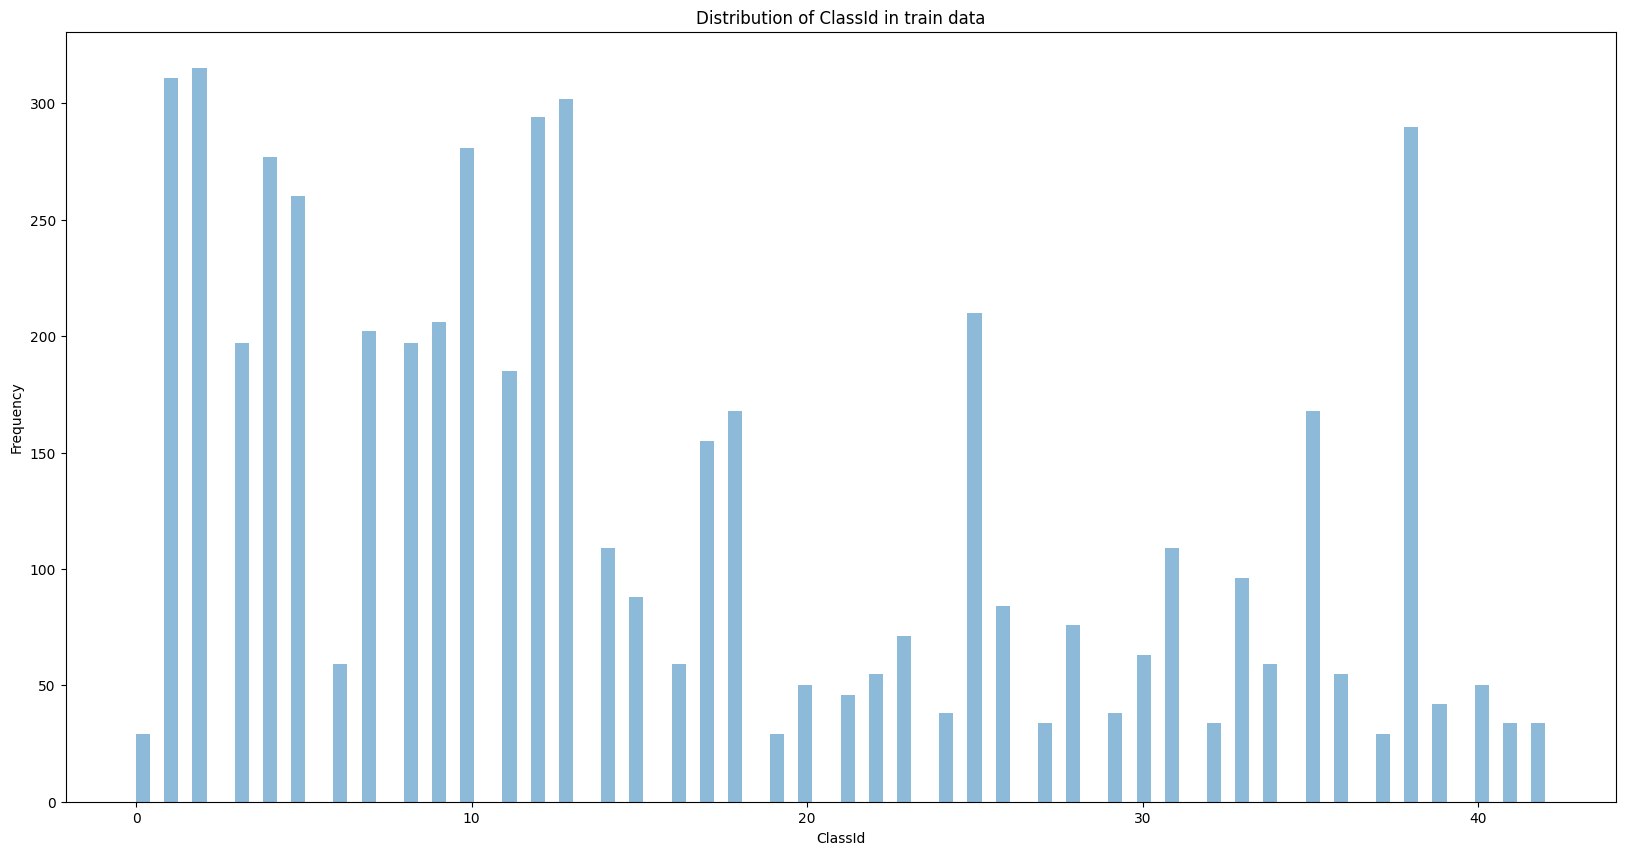

In [ ]:
# do the same for test data?
import matplotlib.pyplot as plt
# lets look at the distribution of the test data:

plt.figure(figsize=(20, 10))
plt.hist(train_meta['ClassId'], bins=100, alpha=0.5, label='train')
plt.title('Distribution of ClassId in train data')
plt.xlabel('ClassId')
plt.ylabel('Frequency')

# Additional Feature extraction

In [9]:
# this seems to make it worse
import cv2
import matplotlib.image as mpimg
import numpy as np

def extract_shape_features(img_path):
    try:
        img = mpimg.imread(img_path)

        # Convert to uint8 if needed
        if img.max() <= 1.0:
            img = (img * 255).astype(np.uint8)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Threshold to binary
        _, binary = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)

        # Find contours
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            largest = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest)

            # Aspect ratio
            aspect_ratio = float(w) / h

            # Extent (area / bounding box area)
            extent = cv2.contourArea(largest) / (w * h + 1e-6)

            # Solidity (area / convex hull area)
            hull = cv2.convexHull(largest)
            hull_area = cv2.contourArea(hull)
            solidity = cv2.contourArea(largest) / (hull_area + 1e-6)

            # Hu Moments (scale/rotation/translation invariant)
            moments = cv2.moments(largest)
            hu_moments = cv2.HuMoments(moments).flatten()

            # Log scale Hu moments to improve stability
            hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-6)

            return [aspect_ratio, extent, solidity] + hu_moments.tolist()

        else:
            # If no contour found, return zeros
            return [0.0] * 10

    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return [0.0] * 10


# Add mean HSV histogram as features for train
for idx, row in train_df.iterrows():
    hsv_feats = extract_shape_features(row["image_path"])
    for k, val in enumerate(hsv_feats):
        train_df.at[idx, f'shape_feat_{k}'] = val

# Add mean HSV histogram as features for test
for idx, row in test_df.iterrows():
    img = mpimg.imread(row["image_path"])
    hsv_feats = extract_shape_features(row["image_path"])
    for k, val in enumerate(hsv_feats):
        test_df.at[idx, f'shape_feat_{k}'] = val


## HSV / LAB information

In [10]:
def extract_hsv_histogram(image_path, num_bins=4):
    """
    Extracts HSV histogram bins from an image.

    Args:
        image_path (str): Path to the image file.
        num_bins (int): Number of bins for the histogram.

    Returns:
        numpy.ndarray: 1D array representing the HSV histogram.
    """
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")

    # Convert to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Calculate the histogram
    # hist = cv2.calcHist([hsv_image], [0, 1, 2], None, [num_bins, num_bins, num_bins], [0, 180, 0, 256, 0, 256])
    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, [8, 4, 4], [0, 180, 0, 256, 0, 256])

    # Normalize and flatten the histogram
    cv2.normalize(hist, hist)
    hist = hist.flatten()

    return hist

In [11]:
# Add mean HSV histogram as features for train
for idx, row in train_df.iterrows():
    hsv_feats = extract_hsv_histogram(row["image_path"])
    for k, val in enumerate(hsv_feats):
        train_df.at[idx, f'hsv_bin_{k}'] = val

# Add mean HSV histogram as features for test
for idx, row in test_df.iterrows():
    img = mpimg.imread(row["image_path"])
    hsv_feats = extract_hsv_histogram(row["image_path"])
    for k, val in enumerate(hsv_feats):
        test_df.at[idx, f'hsv_bin_{k}'] = val

/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_1530/205449982.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df.at[idx, f'hsv_bin_{k}'] = val
/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_1530/205449982.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df.at[idx, f'hsv_bin_{k}'] = val
/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_1530/205449982.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

In [12]:
# remove channel data for now
ch_cols = [c for c in train_df.columns if c.startswith('ch_')]
train_df.drop(ch_cols, axis=1, inplace=True)
test_df.drop(ch_cols, axis=1, inplace=True)


## Edge Density

In [13]:
from scipy import ndimage
import numpy as np
import matplotlib.image as mpimg
# extracting the edge density of each of the images
# this is different from the information we get from the hog pca
# hog gives us the orientation of pixels but edge density gives us the "busyness"
# of the edges of the image, this seems useful for sign stuff

def get_ed(img_path):
    img = mpimg.imread(img_path)

    gx = ndimage.sobel(img, axis=1)               
    gy = ndimage.sobel(img, axis=0)               
    mag = np.hypot(gx, gy)
    edge_density = np.mean(mag > mag.mean())      

    return edge_density

# [get_ed(pth) for pth in train_df["image_path"]]
train_df["ed"] = train_df["image_path"].apply(get_ed)
test_df["ed"] = test_df["image_path"].apply(get_ed)

/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_1530/4283968362.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df["ed"] = train_df["image_path"].apply(get_ed)
/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_1530/4283968362.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df["ed"] = test_df["image_path"].apply(get_ed)


## Colour variance and skew

In [14]:
# get the colour variance and skew per channel
# this is missing from the original features, they have means but not the other moments for colours
def get_color_stats(img_path):
    img = mpimg.imread(img_path)
    r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]

    r_var, g_var, b_var = np.var(r), np.var(g), np.var(b)
    r_skew, g_skew, b_skew = pd.Series(r.flatten()).skew(), pd.Series(g.flatten()).skew(), pd.Series(b.flatten()).skew()

    return r_var, g_var, b_var, r_skew, g_skew, b_skew

dfs = [train_df, test_df]
for df in dfs:
    for row in df.iterrows():
        r_var, g_var, b_var, r_skew, g_skew, b_skew = get_color_stats(row[1]["image_path"])
        df.at[row[0], "r_var"] = r_var
        df.at[row[0], "g_var"] = g_var
        df.at[row[0], "b_var"] = b_var
        df.at[row[0], "r_skew"] = r_skew
        df.at[row[0], "g_skew"] = g_skew
        df.at[row[0], "b_skew"] = b_skew

/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_1530/835917829.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[row[0], "r_var"] = r_var
/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_1530/835917829.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[row[0], "g_var"] = g_var
/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_1530/835917829.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

In [15]:
train_df

,image_path,ClassId,id,shape_feat_0,shape_feat_1,shape_feat_2,shape_feat_3,shape_feat_4,shape_feat_5,shape_feat_6,...,hsv_bin_125,hsv_bin_126,hsv_bin_127,ed,r_var,g_var,b_var,r_skew,g_skew,b_skew
0,train/img_000001.jpg,32,7218,0.950000,0.681579,0.959259,0.793945,3.832760,4.926251,5.982200,...,0.0,0.0,0.0,0.350694,0.021042,0.023334,0.026268,1.040953,1.098451,1.162215
1,train/img_000002.jpg,13,6333,1.076923,0.502747,0.920755,0.718636,4.795738,2.368078,5.751383,...,0.0,0.0,0.0,0.276162,0.018819,0.022255,0.030518,1.188856,1.860768,1.811297
2,train/img_000003.jpg,7,6867,1.061224,0.686617,0.888748,0.761528,3.123667,3.127995,4.607698,...,0.0,0.0,0.0,0.358059,0.110959,0.074273,0.059620,0.319793,0.439914,0.825415
3,train/img_000004.jpg,4,7730,0.952381,0.291667,0.386435,0.266064,1.565967,2.147781,2.241737,...,0.0,0.0,0.0,0.338162,0.004902,0.004954,0.006683,1.175130,1.781462,1.767261
4,train/img_000005.jpg,35,6338,1.000000,0.942042,1.000000,0.778149,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.335640,0.027111,0.019726,0.034961,2.044437,2.303106,0.882210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5483,train/img_005484.jpg,17,456,0.541667,0.621795,0.801653,0.639761,1.605804,4.164367,4.516900,...,0.0,0.0,0.0,0.307802,0.143104,0.102539,0.101914,0.185874,0.833547,1.059753
5484,train/img_005485.jpg,4,4084,1.000000,0.949375,1.000000,0.778149,0.000000,6.000000,6.000000,...,0.0,0.0,0.0,0.346702,0.017843,0.019095,0.016943,1.616173,1.807669,1.412004
5485,train/img_005486.jpg,2,5117,1.000000,0.740593,0.817986,0.764279,2.770023,4.272735,5.717579,...,0.0,0.0,0.0,0.380046,0.123586,0.112273,0.133039,-0.681861,-0.210425,-0.017368
5486,train/img_005487.jpg,3,3334,1.186047,0.379161,0.415127,0.247501,1.188677,2.001601,1.943165,...,0.0,0.0,0.0,0.209412,0.099829,0.109881,0.115890,0.689945,0.665017,0.658464


## GLCM

In [16]:
# import numpy as np
# from skimage.feature import local_binary_pattern
# from skimage.feature import graycomatrix, graycoprops
# from skimage.util import view_as_windows
# from skimage import color

# def extract_glcm_features(img, patch_size=16, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256):
#     """
#     Slide a window of size patch_size×patch_size over `img` (2D, uint8),
#     compute GLCM at each patch, then return arrays of contrast, correlation,
#     energy, homogeneity per patch.
#     """
#     # break into non‑overlapping (or overlapping if you change step) patches
#     patches = view_as_windows(img, (patch_size, patch_size), step=patch_size)
#     nrows, ncols, _, _ = patches.shape

#     features = {
#         'contrast': np.zeros((nrows, ncols)),
#         'correlation': np.zeros((nrows, ncols)),
#         'energy': np.zeros((nrows, ncols)),
#         'homogeneity': np.zeros((nrows, ncols))
#     }

#     for i in range(nrows):
#         for j in range(ncols):
#             patch = patches[i, j]
#             # compute co‑occurrence matrix
#             glcm = graycomatrix(patch,
#                                 distances=distances,
#                                 angles=angles,
#                                 levels=levels,
#                                 symmetric=True,
#                                 normed=True)
#             # average over distances & angles
#             for prop in features:
#                 vals = graycoprops(glcm, prop)  # shape: (n_distances, n_angles)
#                 features[prop][i, j] = vals.mean()

#     return features

# train_df

In [17]:
if False: # takes long
    for idx, row in train_df.iterrows():
        img = mpimg.imread(row["image_path"])
        img_gray = color.rgb2gray(img)
        img = (img_gray * 255).astype(np.uint8)

        glcm_feats = extract_glcm_features(img, patch_size=16)
        # Example: mean of each GLCM property for the image
        train_df.at[idx, 'glcm_contrast'] = glcm_feats['contrast'].mean()
        train_df.at[idx, 'glcm_correlation'] = glcm_feats['correlation'].mean()
        train_df.at[idx, 'glcm_energy'] = glcm_feats['energy'].mean()
        train_df.at[idx, 'glcm_homogeneity'] = glcm_feats['homogeneity'].mean()

## Local Binary Pattern (LBP)

In [18]:
def extract_lbp_features(img, window_size=16, P=8, R=1, method='uniform'):
    lbp_map = local_binary_pattern(img, P=P, R=R, method=method)
    n_bins = int(lbp_map.max() + 1)  # number of uniform patterns + 1

    patches = view_as_windows(lbp_map, (window_size, window_size), step=window_size)
    nrows, ncols, _, _ = patches.shape

    lbp_feats = np.zeros((nrows, ncols, n_bins), dtype=float)

    for i in range(nrows):
        for j in range(ncols):
            patch = patches[i, j].ravel().astype(int)
            # histogram of codes
            hist, _ = np.histogram(patch, bins=np.arange(n_bins+1), density=True)
            lbp_feats[i, j, :] = hist

    return lbp_feats

In [19]:
# Add mean LBP histogram as features
# for idx, row in train_df.iterrows():
#     img = mpimg.imread(row["image_path"])
#     img_gray = color.rgb2gray(img)
#     img = (img_gray * 255).astype(np.uint8)
#     lbp_feats = extract_lbp_features(img)
#     mean_hist = lbp_feats.mean(axis=(0, 1))  # mean histogram over all patches
#     for k, val in enumerate(mean_hist):
#         train_df.at[idx, f'lbp_bin_{k}'] = val


# for idx, row in test_df.iterrows():
#     img = mpimg.imread(row["image_path"])
#     img_gray = color.rgb2gray(img)
#     img = (img_gray * 255).astype(np.uint8)
#     lbp_feats = extract_lbp_features(img)
#     mean_hist = lbp_feats.mean(axis=(0, 1))  # mean histogram over all patches
#     for k, val in enumerate(mean_hist):
#         train_df.at[idx, f'lbp_bin_{k}'] = val

In [20]:
from skimage.feature import local_binary_pattern
from skimage.util import view_as_windows
from skimage import color

# Set your LBP parameters
P = 8
R = 1
METHOD = 'uniform'

# Compute the maximum number of bins for these parameters
dummy_img = np.zeros((16, 16), dtype=np.uint8)
lbp_map = local_binary_pattern(dummy_img, P=P, R=R, method=METHOD)
n_bins = int(lbp_map.max() + 1)

def extract_lbp_features_fixed_bins(img, window_size=16, P=8, R=1, method='uniform', n_bins=None):
    lbp_map = local_binary_pattern(img, P=P, R=R, method=method)
    patches = view_as_windows(lbp_map, (window_size, window_size), step=window_size)
    nrows, ncols, _, _ = patches.shape
    lbp_feats = np.zeros((nrows, ncols, n_bins), dtype=float)
    for i in range(nrows):
        for j in range(ncols):
            patch = patches[i, j].ravel().astype(int)
            hist, _ = np.histogram(patch, bins=np.arange(n_bins+1), density=True)
            lbp_feats[i, j, :] = hist
    return lbp_feats

# Add mean LBP histogram as features for train
for idx, row in train_df.iterrows():
    img = mpimg.imread(row["image_path"])
    img_gray = color.rgb2gray(img)
    img = (img_gray * 255).astype(np.uint8)
    lbp_feats = extract_lbp_features_fixed_bins(img, P=P, R=R, method=METHOD, n_bins=n_bins)
    mean_hist = lbp_feats.mean(axis=(0, 1))
    for k, val in enumerate(mean_hist):
        train_df.at[idx, f'lbp_bin_{k}'] = val

# Add mean LBP histogram as features for test
for idx, row in test_df.iterrows():
    img = mpimg.imread(row["image_path"])
    img_gray = color.rgb2gray(img)
    img = (img_gray * 255).astype(np.uint8)
    lbp_feats = extract_lbp_features_fixed_bins(img, P=P, R=R, method=METHOD, n_bins=n_bins)
    mean_hist = lbp_feats.mean(axis=(0, 1))
    for k, val in enumerate(mean_hist):
        test_df.at[idx, f'lbp_bin_{k}'] = val

/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_1530/1336237829.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df.at[idx, f'lbp_bin_{k}'] = val
/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_1530/1336237829.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df.at[idx, f'lbp_bin_{k}'] = val
/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_1530/1336237829.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, 

## HOG with PCA

In [21]:
import numpy as np
import pandas as pd
from skimage import color
from skimage.feature import hog
from sklearn.decomposition import PCA
import matplotlib.image as mpimg

# HOG + PCA settings
orientations     = 20
pixels_per_cell  = (8, 8)
cells_per_block  = (2, 2)
n_components     = 50  # reduce to min(n_samples, n_features) if needed

def extract_hog_features(img):
    # ensure float in [0,1]
    if img.dtype != np.float32 and img.dtype != np.float64:
        img = img.astype(np.float32) / 255.0

    # convert to gray if RGB
    if img.ndim == 3:
        img = color.rgb2gray(img)
        
    # Resize image to a fixed size to ensure consistent HOG feature dimensions
    from skimage.transform import resize
    img = resize(img, (64, 64), anti_aliasing=True)

    # compute HOG
    return hog(
        img,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        block_norm='L2-Hys',
        visualize=False
    )

# ---- load and extract ----
print("Extracting HOG features (train)...")
train_hog = []
for i, path in enumerate(train_df["image_path"]):
    if i % 100 == 0:
        print(f"Processing train image {i}/{len(train_df)}")
    img = mpimg.imread(path)
    train_hog.append(extract_hog_features(img))
train_hog = np.vstack(train_hog)

print("Extracting HOG features (test)...")
test_hog = []
for i, path in enumerate(test_df["image_path"]):
    if i % 100 == 0:
        print(f"Processing test image {i}/{len(test_df)}")
    img = mpimg.imread(path)
    test_hog.append(extract_hog_features(img))
test_hog = np.vstack(test_hog)

# ---- PCA ----
# cap n_components
max_comp = min(n_components, train_hog.shape[0], train_hog.shape[1])
if n_components > max_comp:
    print(f"Warning: reducing n_components from {n_components} to {max_comp}")
    n_components = max_comp

print(f"Applying PCA → {n_components} components")
pca = PCA(n_components=n_components, svd_solver="auto")
train_pca = pca.fit_transform(train_hog)
test_pca  = pca.transform(test_hog)

# ---- attach back to dfs ----
for i in range(n_components):
    train_df[f"hog_pca_{i}"] = train_pca[:, i]
    test_df[f"hog_pca_{i}"]  = test_pca[:,  i]

print(f"Done — total explained variance: {pca.explained_variance_ratio_.sum():.4f}")


Extracting HOG features (train)...
Processing train image 0/5488
Processing train image 100/5488
Processing train image 200/5488
Processing train image 300/5488
Processing train image 400/5488
Processing train image 500/5488
Processing train image 600/5488
Processing train image 700/5488
Processing train image 800/5488
Processing train image 900/5488
Processing train image 1000/5488
Processing train image 1100/5488
Processing train image 1200/5488
Processing train image 1300/5488
Processing train image 1400/5488
Processing train image 1500/5488
Processing train image 1600/5488
Processing train image 1700/5488
Processing train image 1800/5488
Processing train image 1900/5488
Processing train image 2000/5488
Processing train image 2100/5488
Processing train image 2200/5488
Processing train image 2300/5488
Processing train image 2400/5488
Processing train image 2500/5488
Processing train image 2600/5488
Processing train image 2700/5488
Processing train image 2800/5488
Processing train ima

/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_1530/2206209847.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[f"hog_pca_{i}"] = train_pca[:, i]
/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_1530/2206209847.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[f"hog_pca_{i}"]  = test_pca[:,  i]
/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_1530/2206209847.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

# Shape classification

In [ ]:
# give me an example image for each class so that I can manually get the shapes for classification
import matplotlib.pyplot as plt
import numpy as np
import os

# Create a figure to display one example of each class
plt.figure(figsize=(20, 15))

# Get unique classes
unique_classes = train_df["ClassId"].unique()
unique_classes.sort()  # Sort classes for better organization

# Dictionary to track if we've already found an example for each class
class_examples = {}

# Find one example for each class
for idx, row in train_df.sample(n=1000).iterrows():
    class_id = row["ClassId"]
    if class_id not in class_examples:
        class_examples[class_id] = row["image_path"]
    
    # Break if we have found examples for all classes
    if len(class_examples) == len(unique_classes):
        break

# Plot each example
for i, class_id in enumerate(unique_classes):
    if class_id in class_examples:
        # Create subplot
        plt.subplot(8, 6, i + 1)  # Assuming there are at most 43 classes (standard traffic signs)
        
        # Load and display the image
        img_path = class_examples[class_id]
        img = mpimg.imread(img_path)
        plt.imshow(img)
        
        # Add title with class ID
        plt.title(f"Class {class_id}")
        plt.axis('off')

plt.tight_layout()
plt.show()

# Print the number of classes found
print(f"Found examples for {len(class_examples)} out of {len(unique_classes)} classes")

# Optional: Print the distribution of classes in the training set
class_counts = train_df["ClassId"].value_counts().sort_index()
print("\nClass distribution in training set:")
print(class_counts)




In [453]:

from sklearn.preprocessing import LabelEncoder
# circle: classes 0 - 10, 15 - 17, 32 - 42
# triangle: 11, 13, 18 - 31, 
# Hexagon: 14
# diamond: 12

# encode this in a new column
y_shape = train_df["ClassId"].apply(lambda x: "circle" if x in range(0, 11) or x in range(15, 18) or x in range(32, 43) else
                                    "triangle" if x in range(11, 14) or x in range(18, 32) else
                                    "hexagon" if x == 14 else
                                    "diamond")

y_shape.value_counts()

train_df["Shape"] = LabelEncoder().fit_transform(y_shape)

In [381]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

FEATURES = [c for c in train_df.columns if c not in ("id", "image_path", "ClassId")]

Xshape_train_full = train_df[FEATURES]
Xshape_test = test_df[FEATURES]
y_shape_train_full = train_df["ClassId"]

scaler = StandardScaler().fit(Xshape_train_full)
Xshape_train_full_scaled = scaler.transform(Xshape_train_full)
Xshape_test_scaled  = scaler.transform(Xshape_test)

scaled_train_df = pd.DataFrame(Xshape_train_full_scaled, columns=FEATURES, index=train_df.index)
scaled_test_df  = pd.DataFrame(Xshape_test_scaled, columns=FEATURES, index=test_df.index)

Xshape_train, Xshape_val, yshape_train, yshape_val = train_test_split(
    scaled_train_df,
    y_shape_train_full,
    test_size=0.1,
    random_state=1,
    stratify=y_shape_train_full
)

In [ ]:
# train a svm to classify the shapes
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf = SVC(kernel="linear")

clf.fit(Xshape_train, yshape_train)

y_pred = clf.predict(Xshape_val)
accuracy_score(y_pred, yshape_val)

In [ ]:

Train = False

def load_images(image_paths, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is not None:
            img = cv2.resize(img, (img_width, img_height))
            img = img / 255.0  # Normalize
            images.append(img)
    return np.array(images)
if Train:
    # train a CNN to classify the images into classes
    import tensorflow as tf
    from tensorflow.keras import layers, models
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.applications import MobileNetV2
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
    from sklearn.model_selection import train_test_split
    import numpy as np
    import cv2
    import os

    # Define image dimensions - smaller for faster training
    IMG_HEIGHT, IMG_WIDTH = 96, 96

    # Function to load and preprocess images

    # Get image paths and labels from train_df
    image_paths = train_df['image_path'].values
    labels = y_shape

    # Load images
    X_images = load_images(image_paths)

    # Split data
    X_train_img, X_val_img, y_train_img, y_val_img = train_test_split(
        X_images, labels, test_size=0.2, random_state=42, stratify=labels
    )

    # Data augmentation with fewer transformations for speed
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True
    )

    # Build a faster but still strong CNN model
    def build_cnn_model(num_classes=43):
        # Use MobileNetV2 instead of ResNet50 - much faster but still powerful
        base_model = MobileNetV2(
            weights='imagenet',
            include_top=False,
            input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
            alpha=0.75  # Use a smaller model variant
        )
        
        # Freeze most layers for faster training
        for layer in base_model.layers[:-20]:
            layer.trainable = False
        
        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.BatchNormalization(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5), 
            layers.Dense(num_classes, activation='softmax')
        ])
        
        return model

    cnn_model = build_cnn_model()
    cnn_model.compile(
        optimizer=Adam(learning_rate=0.0005),  # Lower learning rate for better generalization
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Add callbacks
    reduce_lr = ReduceLROnPlateau(
        monitor='val_accuracy',  # Monitor validation accuracy instead of loss
        factor=0.2,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    # Add model checkpoint to save the best model based on validation accuracy
    checkpoint = ModelCheckpoint(
        'shape_cnn.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    # Train model with focus on validation metrics
    history = cnn_model.fit(
        X_train_img, y_train_img,
        batch_size=32,  # Smaller batch size for better generalization
        validation_data=(X_val_img, y_val_img),
        epochs=10,  
        callbacks=[reduce_lr, early_stopping, checkpoint],
        verbose=1
    )

    # Load the best model saved during training
    cnn_model = tf.keras.models.load_model('best_cnn_model.h5')

    # Evaluate model
    val_loss, val_acc = cnn_model.evaluate(X_val_img, y_val_img)
    print(f"Validation accuracy: {val_acc:.4f}")

    # Make predictions on test set
    test_image_paths = test_df['image_path'].values
    X_test_img = load_images(test_image_paths)
    cnn_predictions = cnn_model.predict(X_test_img)
    cnn_pred_classes = np.argmax(cnn_predictions, axis=1)

    # Save CNN predictions
    cnn_pred_df = pd.DataFrame({'id': test_df['id'], 'ClassId': cnn_pred_classes})
    cnn_pred_df.set_index('id', inplace=True)
    # cnn_pred_df.to_csv('cnn_predictions.csv')
else:
    cnn_model = tf.keras.models.load_model('shape_cnn.h5')

    test_image_paths = test_df['image_path'].values
    X_test_img = load_images(test_image_paths)
    cnn_predictions = cnn_model.predict(X_test_img)
    cnn_pred_classes = np.argmax(cnn_predictions, axis=1)
    # ytest_shape = cnn_pred_classes
    test_df["Shape"] = cnn_pred_classes

    # Save CNN predictions
    cnn_pred_df = pd.DataFrame({'id': test_df['id'], 'ClassId': cnn_pred_classes})
    cnn_pred_df.set_index('id', inplace=True)

# Train Val split

In [22]:
len(test_df.columns)

207

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

FEATURES = [c for c in train_df.columns if c not in ("id", "image_path", "ClassId", "Shape")]

X_train_full = train_df[FEATURES]
X_test = test_df[FEATURES]
y_train_full = train_df["ClassId"]

scaler = StandardScaler().fit(X_train_full)
X_train_full_scaled = scaler.transform(X_train_full)
X_train_full_scaled = pd.DataFrame(X_train_full_scaled, columns=FEATURES, index=train_df.index)
# X_train_full_scaled = pd.concat([X_train_full_scaled, pd.DataFrame(ytrain_shape_encoded, columns=["Shape"])], axis=1)

X_test_scaled = scaler.transform(X_test)
scaled_train_df = pd.DataFrame(X_train_full_scaled, columns=FEATURES, index=train_df.index)
scaled_test_df  = pd.DataFrame(X_test_scaled, columns=FEATURES, index=test_df.index)
X_test_scaled = scaled_test_df

# Split indices instead of data directly
train_idx, val_idx = train_test_split(
    scaled_train_df.index,
    test_size=0.1,
    random_state=1,
    stratify=y_train_full
)

pca = PCA(n_components=50)

X_train = pd.DataFrame(scaler.fit_transform(train_df.loc[train_idx][FEATURES]), columns=FEATURES, index = train_df.loc[train_idx].index)
# X_train = scaled_train_df.loc[train_idx]
X_val = pd.DataFrame(scaler.fit_transform(train_df.loc[val_idx][FEATURES]), columns=FEATURES, index = train_df.loc[val_idx].index)
# X_val = scaled_train_df.loc[val_idx]
# Use indices to get train/val splits
y_train = y_train_full.loc[train_idx]
y_val = y_train_full.loc[val_idx]

do_pca = False

if do_pca:
    X_train = pd.DataFrame(pca.fit_transform(X_train), index=train_idx, columns=[f'pca_{i}' for i in range(pca.n_components_)])
    X_val = pd.DataFrame(pca.transform(X_val), index=val_idx, columns=[f'pca_{i}' for i in range(pca.n_components_)])
    X_train_full_scaled = pd.DataFrame(pca.fit_transform(X_train_full_scaled), index=train_df.index, columns=[f'pca_{i}' for i in range(pca.n_components_)])
    X_test_scaled = pd.DataFrame(pca.fit_transform(X_test_scaled), index=test_df.index, columns=[f'pca_{i}' for i in range(pca.n_components_)])


# Post feature extraction visualization

In [453]:
assert set(X_train.columns).difference(set(test_df.columns)) == set()
assert set(X_train.columns).difference(set(train_df.columns)) == set()

In [ ]:
set(train_df.columns).difference(set(test_df.columns))
test_df.columns

In [455]:
from sklearn.preprocessing import StandardScaler
# first normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(train_df.drop(["image_path", "ClassId"], axis=1))
scaled_train_df = pd.DataFrame(scaled_features, columns=train_df.drop(["image_path", "ClassId"], axis=1).columns, index=train_df.index)

scaled_features = scaler.transform(test_df.drop(["image_path"], axis=1))
scaled_test_df = pd.DataFrame(scaled_features, columns=test_df.drop(["image_path"], axis=1).columns, index=test_df.index)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

hog_cols = [c for c in train_df.columns if c.startswith('hog_pca')]
eda_feats = (
    ['edge_density', 'mean_b', 'mean_g', 'mean_r'] +
    hog_cols +
    ['r_var', 'g_var', 'b_var', 'r_skew', 'g_skew', 'b_skew']
)

eda_df = scaled_train_df[eda_feats]

# 3. Plot distributions for each feature
plt.figure(figsize=(16, 12))
eda_df.hist(bins=30, layout=(len(eda_feats) // 4 + 1, 4), figsize=(16, 12))
plt.suptitle("Feature Distributions", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

scatter_df = eda_df.drop(hog_cols, axis = 1) # helps clean up the visualization

#  Sampled scatter‑matrix 
sampled = scatter_df.sample(n=500, random_state=42) # some features are vaguelly linear, logistic regression should be good

sns.pairplot(sampled, diag_kind="kde", corner=True)
plt.suptitle("Pairwise Relationships (500‑point sample)", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# as it is very vague clusters if you can call it that, feature selection needed fs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import numpy as np

# Assuming eda_df and train_df["ClassId"] are aligned and eda_df is numeric
X_reduced = PCA(n_components=3).fit_transform(eda_df)
y = train_df["ClassId"].values

# Set up figure
fig = plt.figure(figsize=(8, 6), dpi=800)
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

# Get unique classes and colors
classes = np.unique(y)
colors = plt.cm.tab20(np.linspace(0, 1, len(classes)))

# Plot each class separately for clean legend
for cls, color in zip(classes, colors):
    idx = y == cls
    ax.scatter(
        X_reduced[idx, 0],
        X_reduced[idx, 1],
        X_reduced[idx, 2],
        label=str(cls),
        color=color,
        s=10,
        alpha=0.6
    )

ax.set_title("PCA: First 3 Principal Components")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.tight_layout()
plt.show()


# Training Machine learning models

In [219]:
pd.DataFrame(X_train.columns).to_clipboard()

In [220]:
y_true_ish = pd.read_csv("91per_cnn.csv")["ClassId"]

## SVM

In [221]:
for col in train_df.columns:
    print(col)

image_path
ClassId
id
shape_feat_0
shape_feat_1
shape_feat_2
shape_feat_3
shape_feat_4
shape_feat_5
shape_feat_6
shape_feat_7
shape_feat_8
shape_feat_9
hsv_bin_0
hsv_bin_1
hsv_bin_2
hsv_bin_3
hsv_bin_4
hsv_bin_5
hsv_bin_6
hsv_bin_7
hsv_bin_8
hsv_bin_9
hsv_bin_10
hsv_bin_11
hsv_bin_12
hsv_bin_13
hsv_bin_14
hsv_bin_15
hsv_bin_16
hsv_bin_17
hsv_bin_18
hsv_bin_19
hsv_bin_20
hsv_bin_21
hsv_bin_22
hsv_bin_23
hsv_bin_24
hsv_bin_25
hsv_bin_26
hsv_bin_27
hsv_bin_28
hsv_bin_29
hsv_bin_30
hsv_bin_31
hsv_bin_32
hsv_bin_33
hsv_bin_34
hsv_bin_35
hsv_bin_36
hsv_bin_37
hsv_bin_38
hsv_bin_39
hsv_bin_40
hsv_bin_41
hsv_bin_42
hsv_bin_43
hsv_bin_44
hsv_bin_45
hsv_bin_46
hsv_bin_47
hsv_bin_48
hsv_bin_49
hsv_bin_50
hsv_bin_51
hsv_bin_52
hsv_bin_53
hsv_bin_54
hsv_bin_55
hsv_bin_56
hsv_bin_57
hsv_bin_58
hsv_bin_59
hsv_bin_60
hsv_bin_61
hsv_bin_62
hsv_bin_63
hsv_bin_64
hsv_bin_65
hsv_bin_66
hsv_bin_67
hsv_bin_68
hsv_bin_69
hsv_bin_70
hsv_bin_71
hsv_bin_72
hsv_bin_73
hsv_bin_74
hsv_bin_75
hsv_bin_76
hsv_bin_77


In [222]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn import metrics
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score

# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=3)

# Create SVM classifier with linear kernel
clf = SVC(kernel="linear", C=1.0)

# Perform cross-validation
cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')

# Print individual fold scores and mean accuracy
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")
print(f"Standard deviation: {cv_scores.std():.4f}")

# Train on full training set and evaluate on validation set for comparison
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred)
print(f"Validation accuracy: {val_accuracy:.4f}")

Cross-validation scores: [0.90587045 0.89979757 0.9048583  0.90283401 0.89057751]
Mean CV accuracy: 0.9008
Standard deviation: 0.0055
Validation accuracy: 0.9235


In [223]:
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import RandomizedSearchCV, HalvingGridSearchCV
from scipy.stats import loguniform
from sklearn.svm import SVC
# Randomized search for a broad region
rnd = RandomizedSearchCV(
    SVC(),
    param_distributions={
        'C': loguniform(1e-1, 1e2),
        'gamma': loguniform(1e-4, 1),
        'kernel': ['linear', 'rbf']
    },
    n_iter=10,
    n_jobs=-1,
    random_state=42,
    verbose=2
)
rnd.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END C=1.3292918943162166, gamma=0.6351221010640696, kernel=linear; total time=   1.1s
[CV] END C=1.3292918943162166, gamma=0.6351221010640696, kernel=linear; total time=   1.1s
[CV] END C=1.3292918943162166, gamma=0.6351221010640696, kernel=linear; total time=   1.1s
[CV] END C=1.3292918943162166, gamma=0.6351221010640696, kernel=linear; total time=   1.1s
[CV] END C=1.3292918943162166, gamma=0.6351221010640696, kernel=linear; total time=   1.1s
[CV] END C=21.830968390524596, gamma=0.024400607090817518, kernel=rbf; total time=   3.1s
[CV] END C=0.2937538457632829, gamma=0.0001707396743152812, kernel=rbf; total time=   2.3s
[CV] END C=0.2937538457632829, gamma=0.0001707396743152812, kernel=rbf; total time=   2.3s
[CV] END C=0.2937538457632829, gamma=0.0001707396743152812, kernel=rbf; total time=   2.4s
[CV] END C=21.830968390524596, gamma=0.024400607090817518, kernel=rbf; total time=   3.4s
[CV] END C=21.830968390524596, 

RandomizedSearchCV(estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x35db0e050>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x31b8f2b10>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, verbose=2)

In [224]:
# Focused halving search around the best found
best = rnd.best_params_
grid_fine = {
    'C': [best['C'] * f for f in [0.5, 1, 2]],
    'gamma': [best['gamma'] * f for f in [0.5, 1, 2]],
    'kernel': ['linear', 'rbf']
}

In [225]:
halving = HalvingGridSearchCV(
    SVC(),
    grid_fine,
    factor=2,
    resource='n_samples',
    max_resources='auto',
    n_jobs=-1,
    verbose=2
)
halving.fit(X_train, y_train)

svm_model = halving.best_estimator_

print("Final best params:", halving.best_params_)

n_iterations: 4
n_required_iterations: 5
n_possible_iterations: 4
min_resources_: 430
max_resources_: 4939
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 18
n_resources: 430
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END C=41.70965147070386, gamma=0.0004266339047829364, kernel=linear; total time=   0.0s
[CV] END C=41.70965147070386, gamma=0.0004266339047829364, kernel=linear; total time=   0.0s
[CV] END C=41.70965147070386, gamma=0.0004266339047829364, kernel=linear; total time=   0.0s
[CV] END C=41.70965147070386, gamma=0.0004266339047829364, kernel=linear; total time=   0.0s
[CV] END C=41.70965147070386, gamma=0.0004266339047829364, kernel=linear; total time=   0.0s
[CV] END C=41.70965147070386, gamma=0.0004266339047829364, kernel=rbf; total time=   0.0s
[CV] END C=41.70965147070386, gamma=0.0004266339047829364, kernel=rbf; total time=   0.0s
[CV] END C=41.70965147070386, gamma=0.0004266339047829364, kernel=rbf; total time=   0.0s
[CV]

In [226]:
y_pred = svm_model.predict(X_val)

print(metrics.classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.80      0.90      0.85        31
           2       0.75      0.84      0.79        32
           3       0.91      1.00      0.95        20
           4       0.97      1.00      0.98        28
           5       0.76      0.62      0.68        26
           6       1.00      1.00      1.00         6
           7       0.80      0.80      0.80        20
           8       0.86      0.95      0.90        20
           9       1.00      0.95      0.98        21
          10       0.96      0.86      0.91        28
          11       0.90      0.95      0.92        19
          12       1.00      1.00      1.00        29
          13       1.00      1.00      1.00        30
          14       1.00      0.91      0.95        11
          15       1.00      0.89      0.94         9
          16       1.00      1.00      1.00         6
          17       1.00    

In [227]:
y_pred = svm_model.predict(X_val)

print(metrics.classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.80      0.90      0.85        31
           2       0.75      0.84      0.79        32
           3       0.91      1.00      0.95        20
           4       0.97      1.00      0.98        28
           5       0.76      0.62      0.68        26
           6       1.00      1.00      1.00         6
           7       0.80      0.80      0.80        20
           8       0.86      0.95      0.90        20
           9       1.00      0.95      0.98        21
          10       0.96      0.86      0.91        28
          11       0.90      0.95      0.92        19
          12       1.00      1.00      1.00        29
          13       1.00      1.00      1.00        30
          14       1.00      0.91      0.95        11
          15       1.00      0.89      0.94         9
          16       1.00      1.00      1.00         6
          17       1.00    

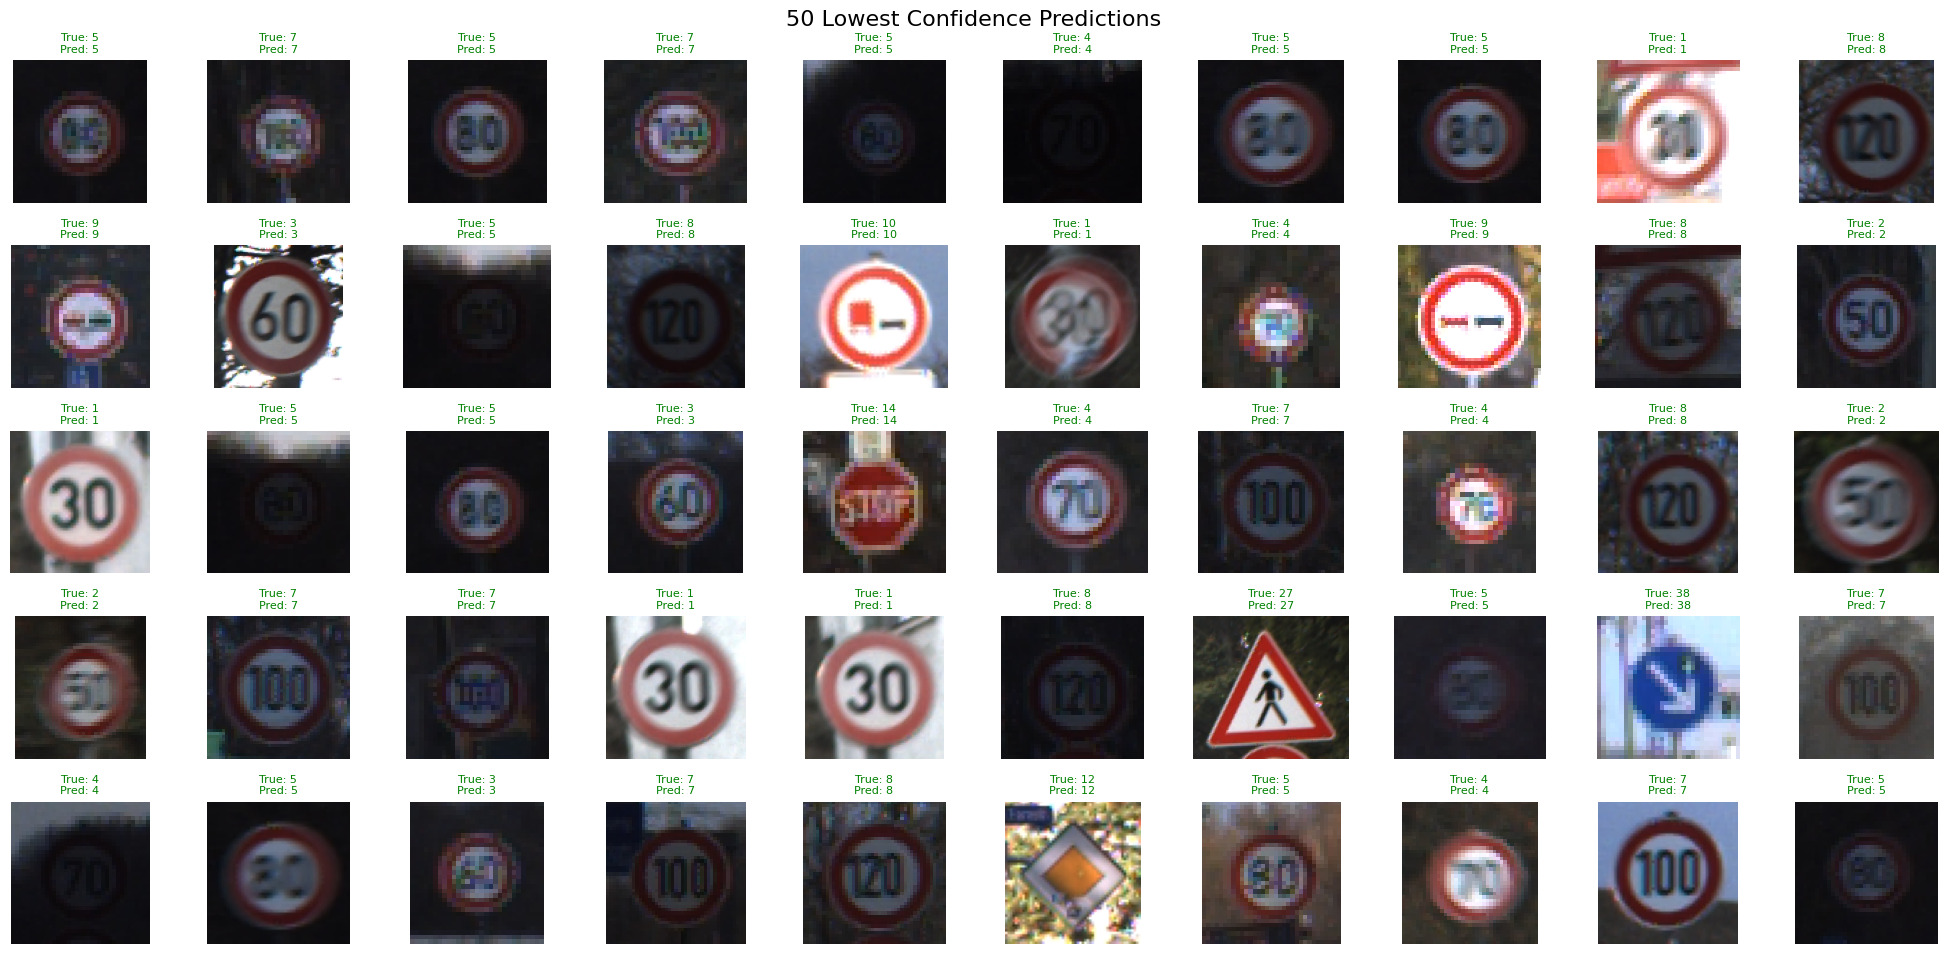


True labels and predictions for the above images:
Image 0: True=5, Pred=5, Correct
Image 1: True=7, Pred=7, Correct
Image 2: True=5, Pred=5, Correct
Image 3: True=7, Pred=7, Correct
Image 4: True=5, Pred=5, Correct
Image 5: True=4, Pred=4, Correct
Image 6: True=5, Pred=5, Correct
Image 7: True=5, Pred=5, Correct
Image 8: True=1, Pred=1, Correct
Image 9: True=8, Pred=8, Correct
Image 10: True=9, Pred=9, Correct
Image 11: True=3, Pred=3, Correct
Image 12: True=5, Pred=5, Correct
Image 13: True=8, Pred=8, Correct
Image 14: True=10, Pred=10, Correct
Image 15: True=1, Pred=1, Correct
Image 16: True=4, Pred=4, Correct
Image 17: True=9, Pred=9, Correct
Image 18: True=8, Pred=8, Correct
Image 19: True=2, Pred=2, Correct
Image 20: True=1, Pred=1, Correct
Image 21: True=5, Pred=5, Correct
Image 22: True=5, Pred=5, Correct
Image 23: True=3, Pred=3, Correct
Image 24: True=14, Pred=14, Correct
Image 25: True=4, Pred=4, Correct
Image 26: True=7, Pred=7, Correct
Image 27: True=4, Pred=4, Correct
Ima

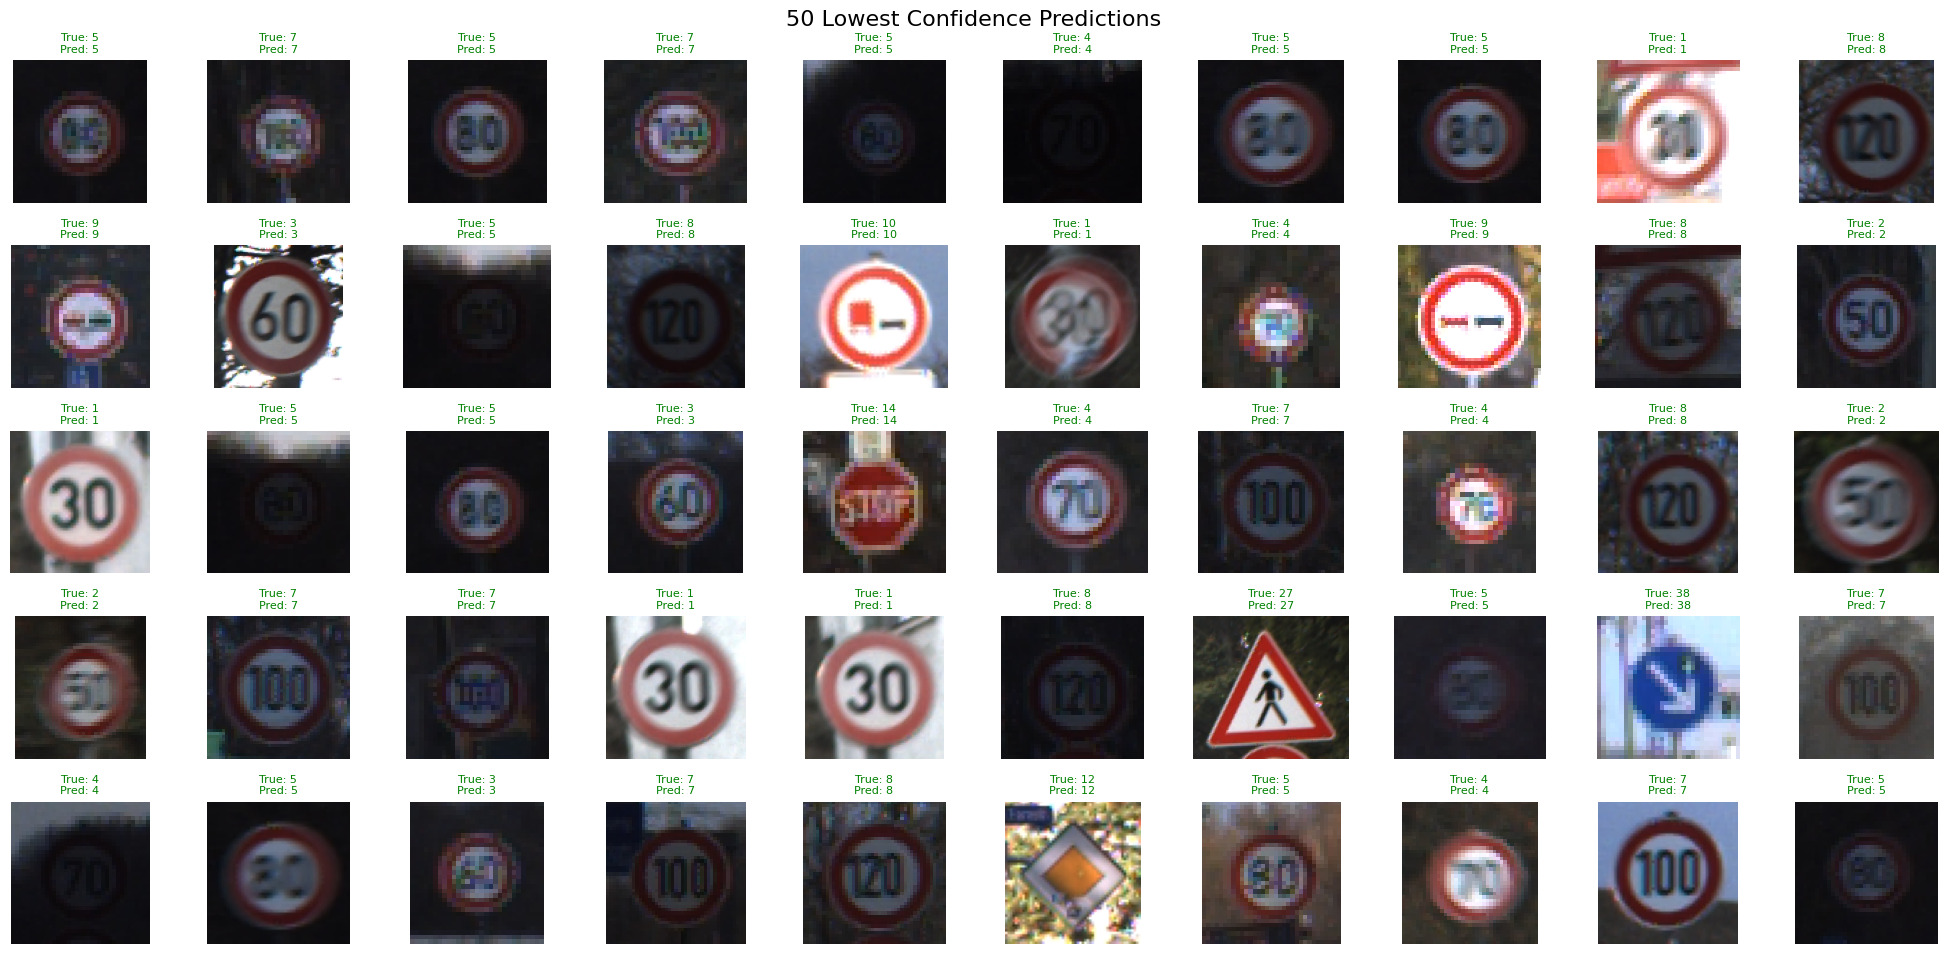

In [228]:
from skimage import io
import matplotlib.pyplot as plt

# Get decision function values and sort by lowest confidence
dists = [(i, val) for i, val in enumerate(np.sum(halving.decision_function(X_train), axis=1))]
dists.sort(key=lambda x: x[1], reverse=False)

# Create figure with better size and spacing
fig, axes = plt.subplots(5, 10, figsize=(20, 10))
axes = axes.flatten()

# Get indices of 50 lowest confidence predictions
worst_indx = [i for i, val in dists[:50]]
vals = X_train.iloc[worst_indx].index

# Get predictions for these samples
predictions = halving.predict(X_train.iloc[worst_indx])

# Plot images with titles showing true class and prediction correctness
for i, (pth, ax) in enumerate(zip(train_df.iloc[vals]["image_path"], axes)):
    myimg = io.imread(pth)
    ax.imshow(myimg)
    true_label = y_train[vals[i]]
    pred_label = predictions[i]
    is_correct = true_label == pred_label
    color = 'green' if is_correct else 'red'
    ax.set_title(f'True: {true_label}\nPred: {pred_label}',
                 fontsize=8, color=color)
    ax.axis('off')

plt.suptitle('50 Lowest Confidence Predictions\n', fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

# Print true labels and predictions for reference
print("\nTrue labels and predictions for the above images:")
for i, (true, pred) in enumerate(zip(y_train[vals], predictions)):
    print(f"Image {i}: True={true}, Pred={pred}, {'Correct' if true==pred else 'Incorrect'}")
from skimage import io
import matplotlib.pyplot as plt

# Get decision function values and sort by lowest confidence
dists = [(i, val) for i, val in enumerate(np.sum(halving.decision_function(X_train), axis=1))]
dists.sort(key=lambda x: x[1], reverse=False)

# Create figure with better size and spacing
fig, axes = plt.subplots(5, 10, figsize=(20, 10))
axes = axes.flatten()

# Get indices of 50 lowest confidence predictions
worst_indx = [i for i, val in dists[:50]]
vals = X_train.iloc[worst_indx].index

# Get predictions for these samples
predictions = halving.predict(X_train.iloc[worst_indx])

# Plot images with titles showing true class and prediction correctness
for i, (pth, ax) in enumerate(zip(train_df.iloc[vals]["image_path"], axes)):
    myimg = io.imread(pth)
    ax.imshow(myimg)
    true_label = y_train[int(vals[i])]
    pred_label = predictions[i]
    is_correct = true_label == pred_label
    color = 'green' if is_correct else 'red'
    ax.set_title(f'True: {true_label}\nPred: {pred_label}',
                 fontsize=8, color=color)
    ax.axis('off')

plt.suptitle('50 Lowest Confidence Predictions\n', fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

# Print true labels and predictions for reference
# print("\nTrue labels and predictions for the above images:")
# for i, (true, pred) in enumerate(zip(y_train[int(vals)], predictions)):
#     print(f"Image {i}: True={true}, Pred={pred}, {'Correct' if true==pred else 'Incorrect'}")


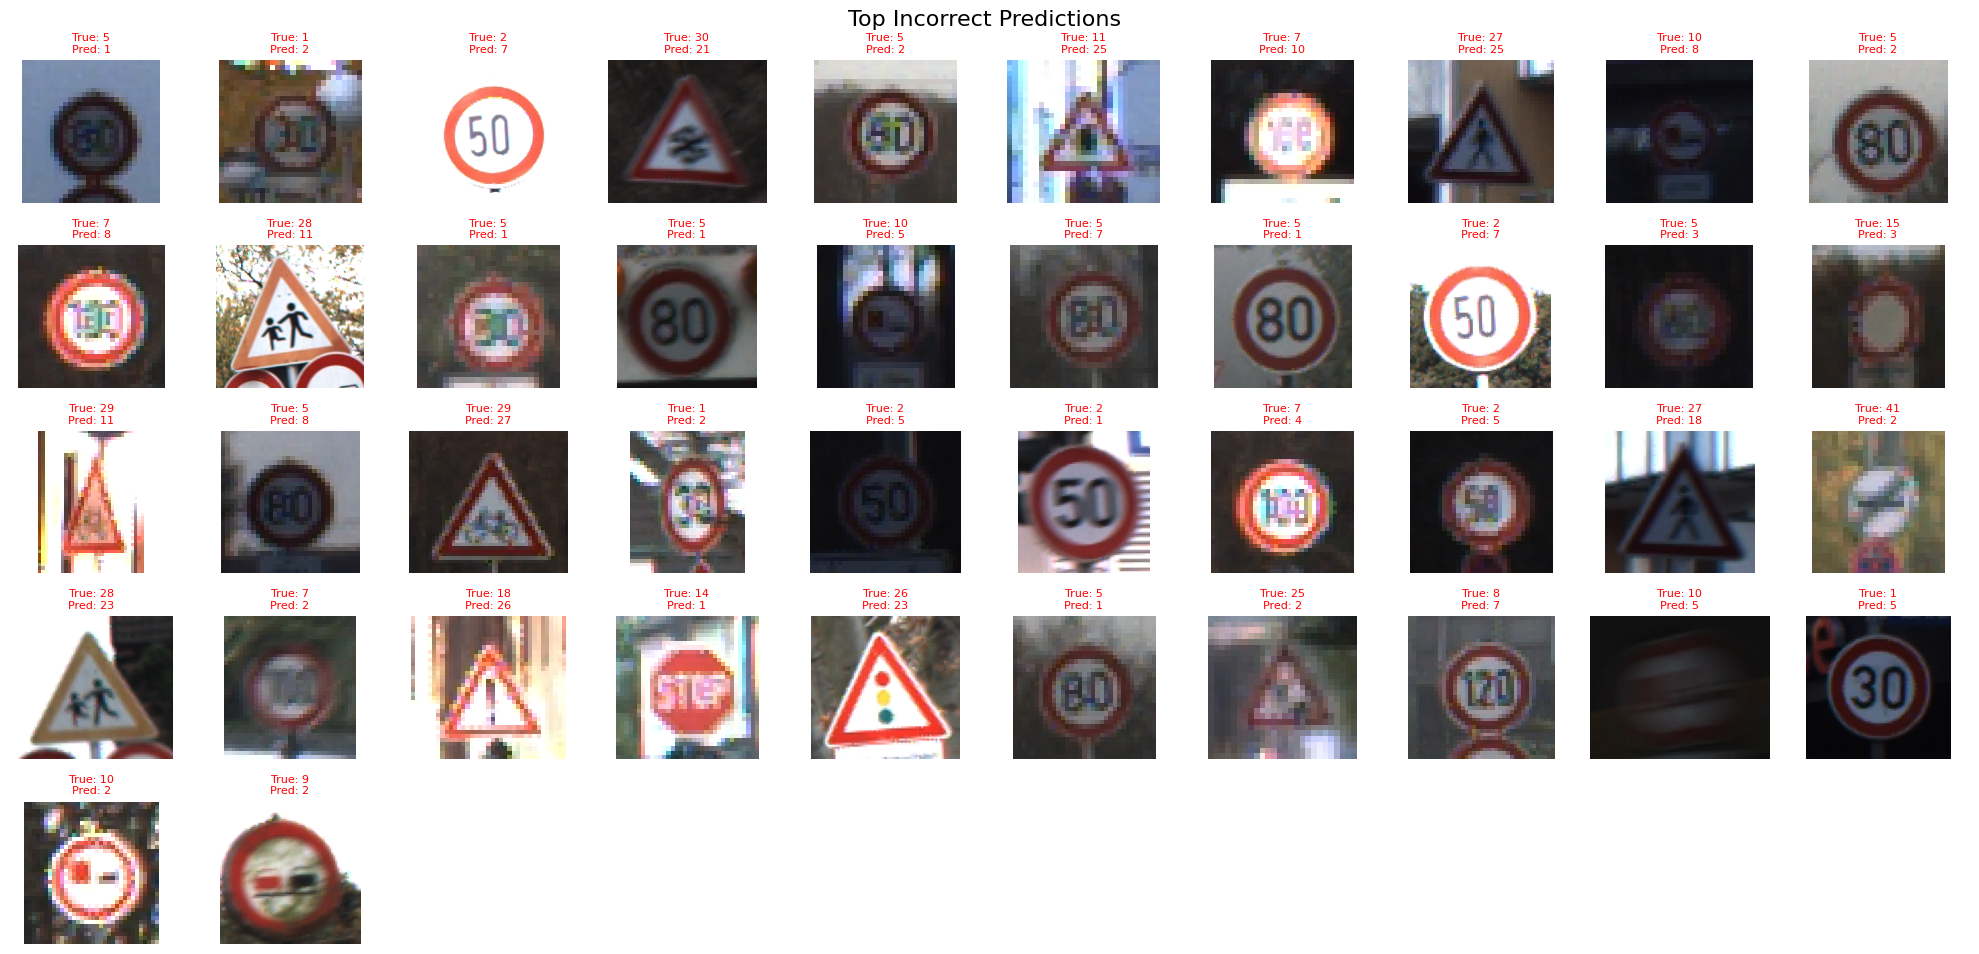

Idx | True -> Pred
  5 | 5 -> 1
  7 | 1 -> 2
 17 | 2 -> 7
 31 | 30 -> 21
 32 | 5 -> 2
 52 | 11 -> 25
 62 | 7 -> 10
 70 | 27 -> 25
126 | 10 -> 8
151 | 5 -> 2
152 | 7 -> 8
158 | 28 -> 11
170 | 5 -> 1
186 | 5 -> 1
211 | 10 -> 5
219 | 5 -> 7
243 | 5 -> 1
283 | 2 -> 7
284 | 5 -> 3
301 | 15 -> 3
306 | 29 -> 11
316 | 5 -> 8
322 | 29 -> 27
326 | 1 -> 2
334 | 2 -> 5
338 | 2 -> 1
350 | 7 -> 4
355 | 2 -> 5
388 | 27 -> 18
391 | 41 -> 2
399 | 28 -> 23
416 | 7 -> 2
441 | 18 -> 26
455 | 14 -> 1
483 | 26 -> 23
485 | 5 -> 1
491 | 25 -> 2
504 | 8 -> 7
514 | 10 -> 5
515 | 1 -> 5
516 | 10 -> 2
520 | 9 -> 2


In [229]:
import matplotlib.pyplot as plt
from skimage import io
import pandas as pd

train_df_val = train_df.iloc[val_idx][["image_path", "ClassId"]].reset_index(drop=True)

val_predictions = svm_model.predict(X_val)

wrong_indices = [i for i, (t, p) in enumerate(zip(y_val, val_predictions)) if t != p]
n_plot = min(len(wrong_indices), 50)

fig, axes = plt.subplots(5, 10, figsize=(20, 10))
axes = axes.flatten()

for ax, idx in zip(axes, wrong_indices[:n_plot]):
    row = train_df_val.loc[idx]                
    img = io.imread(row["image_path"])         
    ax.imshow(img)
    ax.set_title(
        f"True: {row['ClassId']}\nPred: {val_predictions[idx]}",
        fontsize=8, color="red"
    )
    ax.axis("off")

# Turn off any extra axes if less than 50 errors
for ax in axes[n_plot:]:
    ax.axis("off")

plt.suptitle("Top Incorrect Predictions\n", fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

# --- 7. (Optional) Print a summary table ---
print("Idx | True -> Pred")
for idx in wrong_indices[:n_plot]:
    print(f"{idx:3d} | {train_df_val.loc[idx,'ClassId']} -> {val_predictions[idx]}")


In [230]:
# train the svm on the whole train dataset with the best params
clf = SVC(kernel="rbf", C=halving.best_params_["C"], gamma=halving.best_params_["gamma"])

clf.fit(X_train, y_train)

y_pred = pd.DataFrame(clf.predict(X_test_scaled), columns=["ClassId"], index=test_df["id"])
y_pred.index.name = "id"
y_pred.to_csv("svm_predictions.csv", index=True)

print("Test accuracy is: ",accuracy_score(y_pred, y_test_true))

y_pred = clf.predict(X_val)
print("Validation accuracy : ", accuracy_score(y_pred, y_val))


Test accuracy is:  0.9307267318317042
Validation accuracy :  0.941712204007286


## Logistic Regression

In [231]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Create pipeline with preprocessing and classifier
pipe = Pipeline([
    # ('scaler', StandardScaler()),  # Add scaling for better performance
    ('classifier', LogisticRegression(
        max_iter=10000,
        multi_class="multinomial",
        random_state=42, # Add reproducibility
        penalty = "l2"
    ))
])

# Evaluate model with cross-validation
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Train final model on full training set
pipe.fit(X_train, y_train)

# Evaluate on validation set
y_pred = pipe.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred)
print(f"Validation accuracy: {val_accuracy:.3f}")


/Users/duncanjcartwright/Documents/uni_stuff/year3/ML/assignments/ass2/.venvtf/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/duncanjcartwright/Documents/uni_stuff/year3/ML/assignments/ass2/.venvtf/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/duncanjcartwright/Documents/uni_stuff/year3/ML/assignments/ass2/.venvtf/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to

Cross-validation scores: [0.90080972 0.90080972 0.87651822 0.88157895 0.89665653]
Mean CV accuracy: 0.891 (+/- 0.020)
Validation accuracy: 0.885


In [232]:
pipe.fit(X_train_full_scaled, y_train_full)

y_pred = pipe.predict(X_test_scaled)

accuracy_score(y_test_true, y_pred)

/Users/duncanjcartwright/Documents/uni_stuff/year3/ML/assignments/ass2/.venvtf/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


0.888652783680408

## MLP

In [233]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

# Create pipeline with MLP classifier
mlp_pipe = Pipeline([
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(512, 256, 128), 
        activation='relu',
        solver='adam',
        max_iter=2000, # Increased max iterations
        random_state=42,
        early_stopping=True,
        verbose=True,
        learning_rate_init=0.001,
        batch_size=128,
        alpha=0.0001 # L2 regularization
    ))
])

# Evaluate model with cross-validation
cv_scores = cross_val_score(mlp_pipe, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Train final model on full training set
mlp_pipe.fit(X_train, y_train)

# Evaluate on validation set
y_pred = mlp_pipe.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred)
print(f"Validation accuracy: {val_accuracy:.3f}")

# Train on full training data and evaluate on test set
mlp_pipe.fit(X_train_full_scaled, y_train_full)
y_pred = mlp_pipe.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test_true, y_pred)
print(f"Test accuracy: {test_accuracy:.3f}")


Iteration 1, loss = 2.95840044
Validation score: 0.525253
Iteration 2, loss = 1.21189905
Validation score: 0.752525
Iteration 3, loss = 0.47214560
Validation score: 0.787879
Iteration 4, loss = 0.22836652
Validation score: 0.861111
Iteration 5, loss = 0.11553220
Validation score: 0.858586
Iteration 6, loss = 0.06077692
Validation score: 0.881313
Iteration 7, loss = 0.03978067
Validation score: 0.888889
Iteration 8, loss = 0.02429321
Validation score: 0.881313
Iteration 9, loss = 0.01657497
Validation score: 0.888889
Iteration 10, loss = 0.01106364
Validation score: 0.893939
Iteration 11, loss = 0.00865260
Validation score: 0.896465
Iteration 12, loss = 0.00769565
Validation score: 0.893939
Iteration 13, loss = 0.00573343
Validation score: 0.898990
Iteration 14, loss = 0.00480373
Validation score: 0.891414
Iteration 15, loss = 0.00410588
Validation score: 0.891414
Iteration 16, loss = 0.00362655
Validation score: 0.891414
Iteration 17, loss = 0.00321028
Validation score: 0.893939
Iterat

In [234]:
mlp_model = mlp_pipe

## Stacking

In [235]:
import time

rf_model = RandomForestClassifier(
    n_estimators=100,  # Reduced number of trees
    max_depth=10,      # Shallower trees
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42,
    warm_start=True
)

gb_model = GradientBoostingClassifier(
    n_estimators=50,   # Fewer trees
    learning_rate=0.3, # Higher learning rate
    max_depth=4,       # Shallower trees
    min_samples_split=30,
    min_samples_leaf=20,
    subsample=0.7,     # Less data per tree
    random_state=42,
    warm_start=True
)

rf_model.fit(X_train_full_scaled, y_train_full)
# gb_model.fit(X_train_full_scaled, y_train_full)
svm_model.fit(X_train_full_scaled, y_train_full)

print("RF predicting...")
start = time.time()
rf_preds = rf_model.predict(X_train_full_scaled)
print(f"RF done in {time.time() - start:.2f} seconds")

# print("GB predicting...")
# start = time.time()
# gb_preds = gb_model.predict(X_train_full_scaled)
# print(f"GB done in {time.time() - start:.2f} seconds")

print("SVM predicting...")
start = time.time()
svm_preds = svm_model.predict(X_train_full_scaled)
print(f"SVM done in {time.time() - start:.2f} seconds")


RF predicting...
RF done in 0.03 seconds
SVM predicting...
SVM done in 1.44 seconds


In [236]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression


In [ ]:
rf = RandomForestClassifier(
        n_estimators=300, max_depth=20, n_jobs=-1, random_state=42, class_weight='balanced_subsample')
rf.fit(X_train, y_train)
preds = rf.predict(X_val)
accuracy_score(y_val, preds)

0.8506375227686703

In [245]:
svm = SVC(
        kernel='rbf', C=10, gamma='scale', probability=True, random_state=42
    )
rf = svm
rf.fit(X_train, y_train)
preds = rf.predict(X_val)
accuracy_score(y_val, preds)

0.9234972677595629

In [246]:
lr = LogisticRegression(
        max_iter=500, solver='lbfgs', C=3, random_state=42
    )

rf = lr
rf.fit(X_train, y_train)
preds = rf.predict(X_val)
accuracy_score(y_val, preds)

0.8870673952641166

In [237]:
# Stacking: strong, simple, and explainable for tabular/computer vision features

from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

# Base models: strong, diverse, and commonly used for vision tabular features
base_estimators = [
    # Random Forest: robust, handles many features well
    ('rf', RandomForestClassifier(
        n_estimators=300, max_depth=20, n_jobs=-1, random_state=42, class_weight='balanced_subsample'
    )),
    # SVM (RBF): strong for high-dimensional, non-linear data
    ('svm_rbf', make_pipeline(SVC(
        kernel='rbf', C=10, gamma='scale', probability=True, random_state=42
    ))),
    # Logistic Regression: simple, interpretable linear model
    ('lr', make_pipeline(StandardScaler(), LogisticRegression(
        max_iter=500, solver='lbfgs', C=3, random_state=42
    ))),
    # ('mlp', mlp_model)
]

# Meta-learner: Random Forest (robust, non-linear, interpretable feature importances)
meta_learner = RandomForestClassifier(
    n_estimators=500, max_depth=10, n_jobs=-1, random_state=42, class_weight='balanced_subsample'
)

# Stratified K-Fold for reliable out-of-fold predictions
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Stacking ensemble
stacking = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_learner,
    # cv=cv,
    n_jobs=-1,
    passthrough=True
)

# Fit on training data
stacking.fit(X_train, y_train)

# Validation
val_preds = stacking.predict(X_val)
val_acc = accuracy_score(y_val, val_preds)
print(f"Validation accuracy: {val_acc:.5f}")

# Retrain on all data and test
stacking.fit(X_train_full_scaled, y_train_full)
test_preds = stacking.predict(X_test_scaled)
test_acc = accuracy_score(y_test_true, test_preds)
print(f"Test accuracy: {test_acc:.5f}")


Validation accuracy: 0.94900
Test accuracy: 0.93795


In [240]:
# Train XGBoost to classify the images

import xgboost as xgb
from sklearn.metrics import accuracy_score

# XGBoost expects 2D features, so flatten images
X_train_xgb = X_train_img.reshape(X_train_img.shape[0], -1)
X_val_xgb = X_val_img.reshape(X_val_img.shape[0], -1)

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_xgb, label=y_train_img)
dval = xgb.DMatrix(X_val_xgb, label=y_val_img)

# Set XGBoost parameters for multiclass classification
num_classes = len(np.unique(y_train_img))
params = {
    'objective': 'multi:softmax',
    'num_class': num_classes,
    'eval_metric': 'mlogloss',
    'tree_method': 'hist',
    'max_depth': 8,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42,
    'nthread': -1,
}

# Train the model
evals = [(dtrain, 'train'), (dval, 'val')]
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=10
)

# Predict on validation set
val_preds_xgb = xgb_model.predict(dval)
val_acc_xgb = accuracy_score(y_val_img, val_preds_xgb)
print(f"XGBoost validation accuracy: {val_acc_xgb:.5f}")


[0]	train-mlogloss:2.96350	val-mlogloss:3.15573
[10]	train-mlogloss:1.00947	val-mlogloss:1.77844


KeyboardInterrupt: 

## CNN

In [10]:
from sklearn.model_selection import train_test_split
import cv2
# Define image dimensions - smaller for faster training
IMG_HEIGHT, IMG_WIDTH = 96, 96

# Function to load and preprocess images
def load_images(image_paths, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is not None:
            img = cv2.resize(img, (img_width, img_height))
            img = img / 255.0  # Normalize
            images.append(img)
    return np.array(images)

# Get image paths and labels from train_df
image_paths = train_df['image_path'].values
labels = train_df['ClassId'].values

# Load images
X_images = load_images(image_paths)

# Split data
X_train_img, X_val_img, y_train_img, y_val_img = train_test_split(
    X_images, labels, test_size=0.2, random_state=42, stratify=labels
)

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2
cnn_model = tf.keras.models.load_model('best_cnn_model_98_91.keras')
cnn_predictions = cnn_model.predict(load_images([test_df.iloc[0]["image_path"]]))
cnn_pred_classes = np.argmax(cnn_predictions, axis=1)
cnn_pred_classes


# Pick an image to visualize (adjust path as needed)
image_path = test_df['image_path'].iloc[0]
img = cv2.imread(image_path)
img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
img = img / 255.0
img = np.expand_dims(img, axis=0)  # Add batch dimension

# Get the outputs of each layer (excluding the input layer)
layer_outputs = [layer.output for layer in cnn_model.layers if 'activation' in layer.name or 'conv' in layer.name]

# Create a new model that maps the input image to these intermediate layer outputs
activation_model = tf.keras.models.Model(inputs=cnn_model.input, outputs=layer_outputs)

# Run the image through the model
activations = activation_model.predict(img)

# Utility function to display the activation maps
def display_activations(activations, layer_names, max_filters=8):
    for layer_name, activation in zip(layer_names, activations):
        if len(activation.shape) != 4:
            continue  # Skip non-feature map layers
        n_features = min(activation.shape[-1], max_filters)  # Show only a few feature maps
        size = activation.shape[1]
        
        display_grid = np.zeros((size, n_features * size))
        for i in range(n_features):
            feature_map = activation[0, :, :, i]
            feature_map -= feature_map.mean()
            feature_map /= (feature_map.std() + 1e-5)
            feature_map *= 64
            feature_map += 128
            feature_map = np.clip(feature_map, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = feature_map

        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.axis('off')
        plt.show()

# Get layer names for display
layer_names = [layer.name for layer in cnn_model.layers if 'activation' in layer.name or 'conv' in layer.name]

# Show activation maps
display_activations(activations, layer_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


array([34])

In [12]:
# Train a CNN to classify the images into classes
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os

# Define image dimensions - smaller for faster training
IMG_HEIGHT, IMG_WIDTH = 96, 96

# Function to load and preprocess images
def load_images(image_paths, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is not None:
            img = cv2.resize(img, (img_width, img_height))
            img = img / 255.0  # Normalize
            images.append(img)
    return np.array(images, dtype=np.float32)  # Explicitly set dtype to float32

# Get image paths and labels from train_df
image_paths = train_df['image_path'].values
labels = train_df['ClassId'].values.astype(np.int32)  # Convert labels to int32

# Load images
X_images = load_images(image_paths)

# Split data
X_train_img, X_val_img, y_train_img, y_val_img = train_test_split(
    X_images, labels, test_size=0.2, random_state=42, stratify=labels
)

# Data augmentation with fewer transformations for speed
datagen = ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0.00001,
    height_shift_range=0.00001,
    zoom_range=0.001,
    horizontal_flip=False,
    fill_mode='nearest'
)

# Build a faster but still strong CNN model
def build_cnn_model(num_classes=43):
    return tf.keras.models.load_model('best_cnn_model.h5')
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Dense Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

cnn_model = build_cnn_model()
cnn_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Add callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_cnn_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Train model with data augmentation
BATCH_SIZE = 32
history = cnn_model.fit(
    datagen.flow(X_train_img, y_train_img, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train_img) // BATCH_SIZE,
    validation_data=(X_val_img, y_val_img),
    epochs=40,
    callbacks=[reduce_lr, early_stopping, checkpoint],
    verbose=1
)

# Evaluate model
val_loss, val_acc = cnn_model.evaluate(X_val_img, y_val_img)
print(f"Validation accuracy: {val_acc:.4f}")

# Make predictions on test set
test_image_paths = test_df['image_path'].values
X_test_img = load_images(test_image_paths)
cnn_predictions = cnn_model.predict(X_test_img)
cnn_pred_classes = np.argmax(cnn_predictions, axis=1)

# Save CNN predictions
cnn_pred_df = pd.DataFrame({'id': test_df['id'], 'ClassId': cnn_pred_classes})
cnn_pred_df.set_index('id', inplace=True)
cnn_pred_df.to_csv('cnn_predictions.csv')

Epoch 1/40


/Users/duncanjcartwright/Documents/uni_stuff/year3/ML/assignments/ass2/tf-metal/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "conv2d" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 96, 96, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 96, 96, 3), dtype=float32)
  • training=True
  • mask=None

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2

# Pick an image to visualize (adjust path as needed)
image_path = test_df['image_path'].iloc[0]
img = cv2.imread(image_path)
img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
img = img / 255.0
img = np.expand_dims(img, axis=0)  # Add batch dimension

# Get the outputs of each layer (excluding the input layer)
layer_outputs = [layer.output for layer in cnn_model.layers if 'activation' in layer.name or 'conv' in layer.name]

# Create a new model that maps the input image to these intermediate layer outputs
activation_model = tf.keras.models.Model(inputs=cnn_model.input, outputs=layer_outputs)

# Run the image through the model
activations = activation_model.predict(img)

# Utility function to display the activation maps
def display_activations(activations, layer_names, max_filters=8):
    for layer_name, activation in zip(layer_names, activations):
        if len(activation.shape) != 4:
            continue  # Skip non-feature map layers
        n_features = min(activation.shape[-1], max_filters)  # Show only a few feature maps
        size = activation.shape[1]
        
        display_grid = np.zeros((size, n_features * size))
        for i in range(n_features):
            feature_map = activation[0, :, :, i]
            feature_map -= feature_map.mean()
            feature_map /= (feature_map.std() + 1e-5)
            feature_map *= 64
            feature_map += 128
            feature_map = np.clip(feature_map, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = feature_map

        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.axis('off')
        plt.show()

# Get layer names for display
layer_names = [layer.name for layer in cnn_model.layers if 'activation' in layer.name or 'conv' in layer.name]

# Show activation maps
display_activations(activations, layer_names)


In [ ]:
# Train a CNN to classify the images into classes
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os

# Define image dimensions - larger for better feature extraction
IMG_HEIGHT, IMG_WIDTH = 224, 224

# Function to load and preprocess images with advanced augmentation
def load_images(image_paths, img_height=IMG_HEIGHT, img_width=IMG_WIDTH, augment=True):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is not None:
            img = cv2.resize(img, (img_width, img_height))
            img = img / 255.0  # Normalize
            
            if augment:
                # Apply random augmentations
                if np.random.random() > 0.5:
                    img = cv2.flip(img, 1)  # Random horizontal flip
                if np.random.random() > 0.5:
                    angle = np.random.uniform(-15, 15)
                    M = cv2.getRotationMatrix2D((img_width/2, img_height/2), angle, 1)
                    img = cv2.warpAffine(img, M, (img_width, img_height))
                if np.random.random() > 0.5:
                    brightness = np.random.uniform(0.8, 1.2)
                    img = img * brightness
                    img = np.clip(img, 0, 1)
            
            images.append(img)
    return np.array(images)

# Get image paths and labels from train_df
image_paths = train_df['image_path'].values
labels = train_df['ClassId'].values

# Load images with augmentation
X_images = load_images(image_paths, augment=True)

# Split data
X_train_img, X_val_img, y_train_img, y_val_img = train_test_split(
    X_images, labels, test_size=0.2, random_state=42, stratify=labels
)

# Build a powerful CNN model using EfficientNetV2L
def build_cnn_model(num_classes=43):
    # Use EfficientNetV2L as base model - state of the art architecture
    # base_model = EfficientNetV2L(
    #     weights='imagenet',
    #     include_top=False,
    #     input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    # )

    # base_model = MobileNetV2(
    #     weights='imagenet',
    #     include_top=False,
    #     input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    #     # alpha=0.75  # Use a smaller model variant
    # )
    
    # # Unfreeze more layers for better feature extraction
    # for layer in base_model.layers[:-30]:
    #     layer.trainable = False
    
    # model = models.Sequential([
    #     base_model,
    #     layers.GlobalAveragePooling2D(),
    #     layers.BatchNormalization(),
    #     layers.Dense(1024, activation='relu'),
    #     layers.Dropout(0.4),
    #     layers.Dense(512, activation='relu'),
    #     layers.Dropout(0.3),
    #     layers.Dense(256, activation='relu'),
    #     layers.Dropout(0.2),
    #     layers.Dense(num_classes, activation='softmax')
    # ])

    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Dense Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    
    return model

cnn_model = build_cnn_model()
cnn_model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for better generalization
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Enhanced callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_cnn_model.keras',  # Using .keras format as recommended
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Train model with focus on validation metrics
history = cnn_model.fit(
    X_train_img, y_train_img,
    batch_size=16,  # Smaller batch size for better generalization
    validation_data=(X_val_img, y_val_img),
    epochs=50,  # More epochs with early stopping
    callbacks=[reduce_lr, early_stopping, checkpoint],
    verbose=1
)

# Load the best model saved during training
cnn_model = tf.keras.models.load_model('best_cnn_model.keras')

# Evaluate model
val_loss, val_acc = cnn_model.evaluate(X_val_img, y_val_img)
print(f"Validation accuracy: {val_acc:.4f}")

# Make predictions on test set
test_image_paths = test_df['image_path'].values
X_test_img = load_images(test_image_paths, augment=False)  # No augmentation for test set
cnn_predictions = cnn_model.predict(X_test_img)
cnn_pred_classes = np.argmax(cnn_predictions, axis=1)

# Save CNN predictions
cnn_pred_df = pd.DataFrame({'id': test_df['id'], 'ClassId': cnn_pred_classes})
cnn_pred_df.set_index('id', inplace=True)
cnn_pred_df.to_csv('cnn_predictions.csv')

In [ ]:
# Train a CNN to classify the images into classes
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import EfficientNetV2B3, MobileNetV
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os

# Define image dimensions - optimized for traffic signs
IMG_HEIGHT, IMG_WIDTH = 96, 96  # Reduced size for faster training while maintaining quality

# Function to load and preprocess images with optimized augmentation
def load_images(image_paths, img_height=IMG_HEIGHT, img_width=IMG_WIDTH, augment=False):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is not None:
            img = cv2.resize(img, (img_width, img_height))
            img = img / 255.0  # Normalize
            
            if augment:
                # Enhanced augmentation strategy
                if np.random.random() > 0.5:
                    img = cv2.flip(img, 1)  # Random horizontal flip
                if np.random.random() > 0.5:
                    angle = np.random.uniform(-10, 10)  # Reduced rotation range
                    M = cv2.getRotationMatrix2D((img_width/2, img_height/2), angle, 1)
                    img = cv2.warpAffine(img, M, (img_width, img_height))
                if np.random.random() > 0.5:
                    # Add slight blur to simulate different focus conditions
                    blur_size = np.random.choice([3, 5])
                    img = cv2.GaussianBlur(img, (blur_size, blur_size), 0)
                if np.random.random() > 0.5:
                    # Add slight noise to improve robustness
                    noise = np.random.normal(0, 0.01, img.shape)
                    img = np.clip(img + noise, 0, 1)
            
            images.append(img)
    return np.array(images)

# Get image paths and labels from train_df
image_paths = train_df['image_path'].values
labels = train_df['ClassId'].values.astype(np.int32)  # Ensure labels are integers

# Load images with augmentation
X_images = load_images(image_paths, augment=True)

# Split data with stratification
X_train_img, X_val_img, y_train_img, y_val_img = train_test_split(
    X_images, labels, test_size=0.15, random_state=42, stratify=labels
)

# Build an optimized CNN model
def build_cnn_model(num_classes=43):
    # Use EfficientNetV2B3 as base model - better balance of speed and accuracy
    # base_model = EfficientNetV2B3(
    #     weights='imagenet',
    #     include_top=False,
    #     input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    # )

    # base_model = MobileNetV2(
    #     weights='imagenet',
    #     include_top=False,
    #     input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    #     # alpha=0.75  # Use a smaller model variant
    # )
    
    # # Freeze early layers, fine-tune later layers
    # for layer in base_model.layers[:-20]:
    #     layer.trainable = False
    
    # model = models.Sequential([
    #     base_model,
    #     layers.GlobalAveragePooling2D(),
    #     layers.BatchNormalization(),
    #     layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    #     layers.Dropout(0.3),
    #     layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    #     layers.Dropout(0.2),
    #     layers.Dense(num_classes, activation='softmax')
    # ])

    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Dense Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    
    return model

cnn_model = build_cnn_model()
cnn_model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=0.0001),  # Using AdamW with weight decay
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Optimized callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_cnn_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Train model with optimized parameters
history = cnn_model.fit(
    X_train_img, y_train_img,
    batch_size=32,  # Increased batch size for faster training
    validation_data=(X_val_img, y_val_img),
    epochs=100,  # More epochs with better early stopping
    callbacks=[reduce_lr, early_stopping, checkpoint],
    verbose=1
)

# Load the best model saved during training
cnn_model = tf.keras.models.load_model('best_cnn_model.keras')

# Evaluate model
val_loss, val_acc = cnn_model.evaluate(X_val_img, y_val_img)
print(f"Validation accuracy: {val_acc:.4f}")

# Make predictions on test set
test_image_paths = test_df['image_path'].values
X_test_img = load_images(test_image_paths, augment=False)  # No augmentation for test set
cnn_predictions = cnn_model.predict(X_test_img)
cnn_pred_classes = np.argmax(cnn_predictions, axis=1)

# Save CNN predictions
cnn_pred_df = pd.DataFrame({'id': test_df['id'], 'ClassId': cnn_pred_classes})
cnn_pred_df.set_index('id', inplace=True)
cnn_pred_df.to_csv('cnn_predictions.csv')

In [ ]:
from tensorflow.keras import layers, models

def build_custom_cnn(input_shape=(128, 128, 3), num_classes=43):
    inputs = layers.Input(shape=input_shape)
    
    # ---- Feature extractor ----
    x = layers.Conv2D(32, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(32, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2, 2)(x)   # changed from (3,strides=2)

    # ---- Residual block with projection ----
    shortcut = x
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    # project shortcut up to 64 channels
    shortcut = layers.Conv2D(64, 1, padding='same')(shortcut)
    shortcut = layers.BatchNormalization()(shortcut)
    
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2, 2)(x)

    # ---- Deeper conv block ----
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2, 2)(x)

    # ---- Classification head ----
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return models.Model(inputs, outputs)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
NUM_CLASSES = 43

# 1) Data pipeline (tf.data)
def preprocess(image, label, training=False):
    # image is float32 [0,1] from your loader
    # 1) resize
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    # 2) augmentation
    if training:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, 0.2)
        image = tf.image.random_contrast(image, 0.8, 1.2)
    # 3) model-specific preprocessing
    image = preprocess_input(image)  
    # 4) one-hot
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

def make_datasets(X, y):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.shuffle(len(X)).map(lambda i, l: preprocess(i, l, training=True),
                                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

def make_val_dataset(X, y):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.map(lambda i, l: preprocess(i, l, training=False),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_datasets(X_train_img, y_train_img)
val_ds   = make_val_dataset(X_val_img,   y_val_img)

# 2) Build the model
def build_transfer_model():
    # a) Load pretrained base
    base = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    base.trainable = False  # freeze entire backbone

    # b) Attach new head
    inputs = layers.Input((IMG_HEIGHT, IMG_WIDTH, 3))
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    return models.Model(inputs, outputs)

model = build_transfer_model()
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 3) Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.2, patience=2, min_lr=1e-6, verbose=1
)
early = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
chkpt = ModelCheckpoint('best_effnet.keras', monitor='val_accuracy',
                        save_best_only=True, verbose=1)

# 4) Train only head
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[reduce_lr, early, chkpt]
)

# 5) Fine-tune: unfreeze last 20 layers of the base
base = model.layers[1]  # EfficientNetB0
base.trainable = True
for layer in base.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[reduce_lr, early, chkpt]
)

# 6) Load best weights & evaluate
model = tf.keras.models.load_model('best_effnet.keras')
val_loss, val_acc = model.evaluate(val_ds)
print(f"Fine-tuned validation accuracy: {val_acc:.4f}")


In [ ]:
cnn_pred_df.to_csv('cnn_predictions.csv')

# Ensembles

In [ ]:
# implement bagging with improved parameters
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

base_estimator = DecisionTreeClassifier(
    max_features='sqrt',
    class_weight='balanced',
    min_samples_split=5
)

param_dist = {
    'n_estimators': randint(200, 500),
    'max_samples': [0.7, 0.8, 0.9, 1.0],
    'max_features': [0.7, 0.8, 0.9, 1.0],
    'bootstrap': [True],
    'bootstrap_features': [True, False]
}

# Create bagging classifier
bagging = BaggingClassifier(
    estimator=base_estimator,
    n_jobs=-1,
    random_state=1
)

# Use randomized search for hyperparameter tuning
clf = RandomizedSearchCV(
    bagging,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    random_state=1,
    n_jobs=-1,
    verbose=1
)

# Fit the model
clf.fit(X_train, y_train)

# Print best parameters
print(f"Best parameters: {clf.best_params_}")

# Make predictions with best model
y_pred = clf.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_pred, y_val)

print(f"Best accuracy: {accuracy}")

accuracy

In [ ]:
# random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

accuracy_score(y_pred, y_val)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score  

model = XGBClassifier(n_estimators=200, max_depth=20, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

accuracy_score(y_pred, y_val)

In [ ]:
# train the xgb model on the whole train dataset with the best params
best_params = {'colsample_bytree': np.float64(0.7297380084021096), 'gamma': np.float64(0.061043977350336676), 'learning_rate': np.float64(0.11688935142309247), 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 426, 'subsample': np.float64(0.8590760482165449)}
# best_params = clf.best_params_

clf = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', **best_params)

clf.fit(X_train_full_scaled, y_train_full)

y_pred = clf.predict(X_test_scaled)

In [ ]:
# in sample accuracy:
y_pred_in = clf.predict(X_train)
accuracy_score(y_pred_in, y_train) # = 1.0 -> overfitted?

In [493]:
# save predictions to csv
y_pred = pd.DataFrame({"id": test_df["id"], "ClassId": y_pred})

y_pred.to_csv("xgb_predictions.csv", index=False)

In [475]:
assert len(y_pred) == len(test_df), "Prediction count doesn't match test set!"
assert all(y_pred["id"] == test_df["id"]), "Prediction ids are out of order!"

In [ ]:
print("Train classes:", sorted(y_train.unique()))
print("Test prediction classes:", np.unique(y_pred["ClassId"]))

# Feature engineering

In [477]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X_train, y_train)

In [478]:
MI_cols = X_train.columns[mi_scores > 0.2]
MI_train = X_train[X_train.columns[mi_scores > 0.2]]

In [ ]:
mi_scores